In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import regularizers,backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.utils import load_img, img_to_array
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imshow
from PIL import Image, ImageFilter

sns.set_style('darkgrid')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/dataset1"

'batik-geblek renteng'	'batik-mega mendung'    batik-sidoarjo	 batik-tumpal
 batik-gunungan		 batik-parang	        batik-simbut
 batik-kawung		'batik-pring sedapur'   batik-truntum


In [4]:
sdir=r'/content/drive/My Drive/dataset1'


filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head(5))
print (df['labels'].value_counts())

                                           filepaths         labels
0  /content/drive/My Drive/dataset1/batik-truntum...  batik-truntum
1  /content/drive/My Drive/dataset1/batik-truntum...  batik-truntum
2  /content/drive/My Drive/dataset1/batik-truntum...  batik-truntum
3  /content/drive/My Drive/dataset1/batik-truntum...  batik-truntum
4  /content/drive/My Drive/dataset1/batik-truntum...  batik-truntum
batik-truntum           251
batik-kawung            250
batik-gunungan          250
batik-parang            250
batik-mega mendung      250
batik-geblek renteng    250
batik-simbut            250
batik-pring sedapur     250
batik-tumpal            250
batik-sidoarjo          250
Name: labels, dtype: int64


In [5]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  2000   test_df length:  250   valid_df length:  251


In [6]:
height=224
width=224
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

# Data Augmenation
gen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
    
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)

test batch size:  50   test steps:  5
Found 1999 validated image filenames belonging to 10 classes.
Found 251 validated image filenames belonging to 10 classes.
Found 250 validated image filenames belonging to 10 classes.
['batik-geblek renteng', 'batik-gunungan', 'batik-kawung', 'batik-mega mendung', 'batik-parang', 'batik-pring sedapur', 'batik-sidoarjo', 'batik-simbut', 'batik-truntum', 'batik-tumpal']


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [7]:
def image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

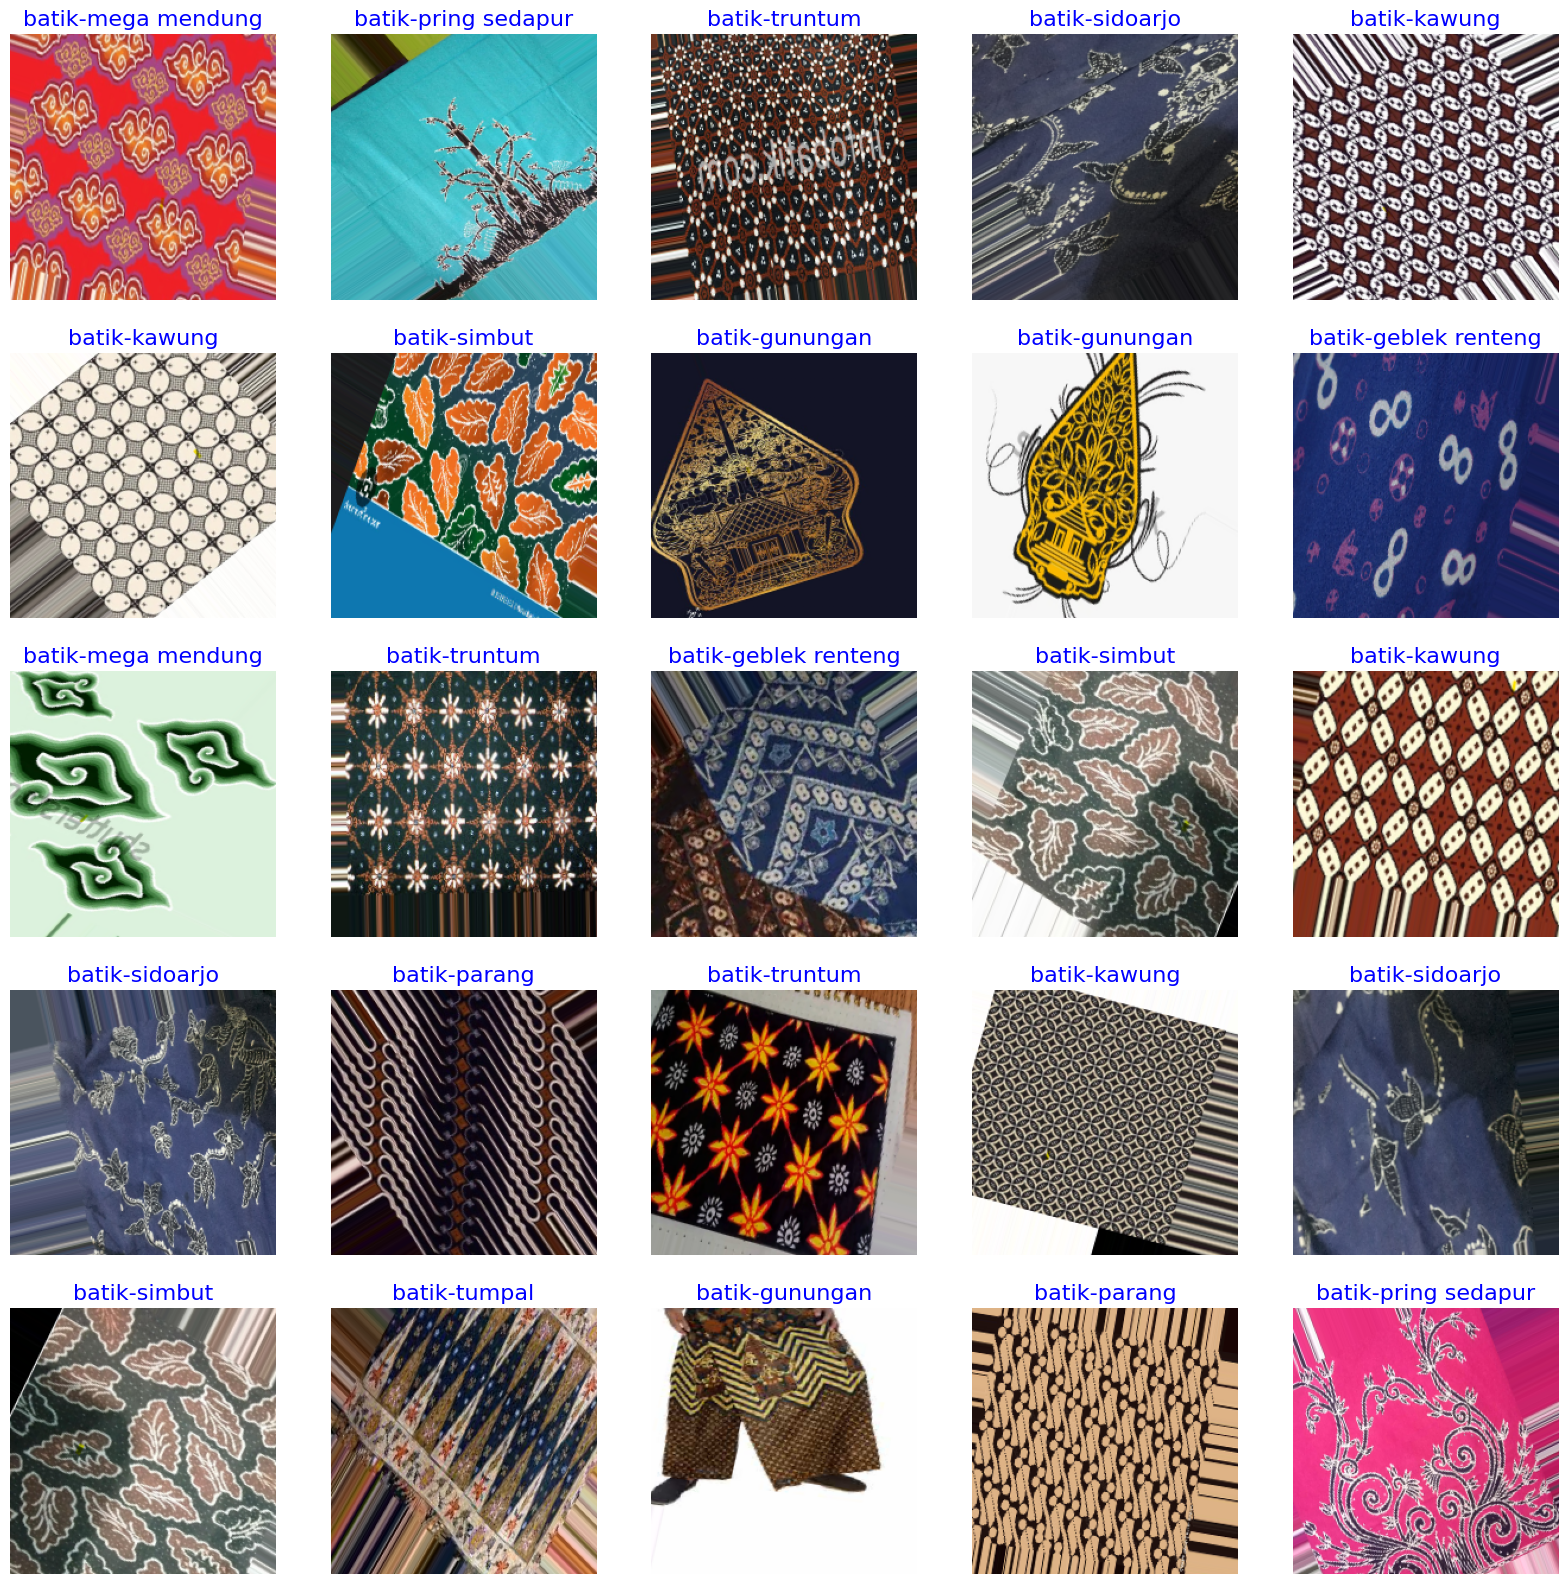

In [8]:
image_samples(train_gen)

In [9]:
#apply transfer learning Xception for image classification
base_model=tf.keras.applications.Xception(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3))) 
base_model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [10]:
base_model.trainable = False

In [11]:
model_name='BatikIN'
print("Building model with", base_model)
model = tf.keras.Sequential([
            #base_model is a transfer learning model
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.engine.functional.Functional object at 0x7f26a42241c0>


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 32)          589856    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 10)                2890      
                                                        

In [13]:
epochs =100

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/100
32/32 [==============================] - 764s 23s/step - loss: 1.7837 - accuracy: 0.3922 - val_loss: 1.0492 - val_accuracy: 0.6773
Epoch 2/100
32/32 [==============================] - 98s 3s/step - loss: 1.1391 - accuracy: 0.6173 - val_loss: 0.7413 - val_accuracy: 0.7570
Epoch 3/100
32/32 [==============================] - 96s 3s/step - loss: 0.7546 - accuracy: 0.7484 - val_loss: 0.5568 - val_accuracy: 0.8406
Epoch 4/100
32/32 [==============================] - 98s 3s/step - loss: 0.5811 - accuracy: 0.7994 - val_loss: 0.3457 - val_accuracy: 0.9004
Epoch 5/100
32/32 [==============================] - 96s 3s/step - loss: 0.4979 - accuracy: 0.8374 - val_loss: 0.3390 - val_accuracy: 0.9004
Epoch 6/100
32/32 [==============================] - 96s 3s/step - loss: 0.4347 - accuracy: 0.8564 - val_loss: 0.3739 - val_accuracy: 0.8805
Epoch 7/100
32/32 [==============================] - 102s 3s/step - loss: 0.2962 - accuracy: 0.9135 - val_loss: 0.2046 - val_accuracy: 0.9482
Epoch 8/10

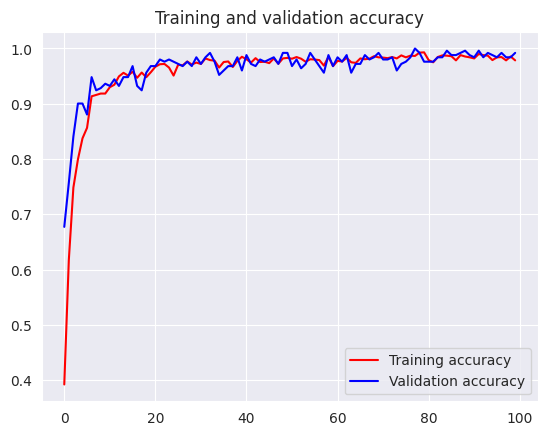

<Figure size 640x480 with 0 Axes>

In [14]:

# Plot the results 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [20]:
# dictionary = {0 : 'batik-geblek renteng',  
        #        1 : 'batik-gunungan',
        #        2 : 'batik-kawung', 
        #        3 : 'batik-mega mendung',
        #        4 : 'batik-parang'}
        #        5 : 'batik-pring sedapur'}
        #        6 : 'batik-sidoarjo'}
        #        7 : 'batik-simbut'}
        #        8 : 'batik-truntum'}
        #        9 : 'batik-tumpal'}



uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  i = load_img(path, target_size=(224, 224))
  i = img_to_array(i)/255.0
  i=i.reshape(1, 224,224,3)
  p=model.predict(i)
  predicted_class_index = np.argmax(p[0])


  print(fn)
  print(predicted_class_index)

Saving tumpal.jpg to tumpal.jpg
1/1 [==============================] - 0s 35ms/step
tumpal.jpg
9


In [18]:
model.save('model ML update.h5')